# Exploring the Data
Exploration of Quarterly Reports and their likelihood to influence future price movement in the following report.

## Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle

### Loading the Data

In [2]:
with open("main_df.pkl",'rb') as fp:
    final_df = pickle.load(fp)

## Visualizing the count of Buy, Hold, and Sells
Visual check for any class imbalance among the quarterly reports.

In [3]:
# Separating each class into respective DataFrames
buy_df = final_df[final_df['Decision']==1].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
hold_df = final_df[final_df['Decision']==2].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
sell_df = final_df[final_df['Decision']==0].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)

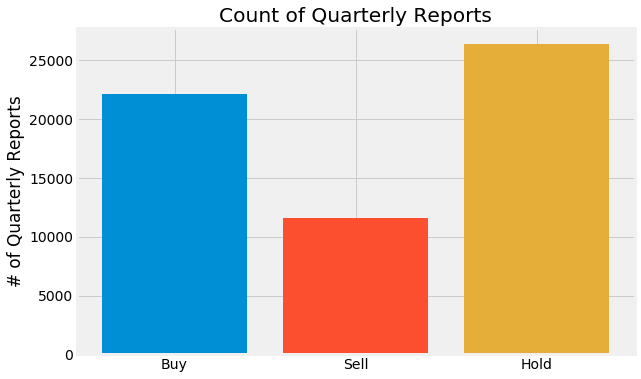

In [4]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Buy", buy_df.shape[0])
plt.bar("Sell", sell_df.shape[0])
plt.bar("Hold", hold_df.shape[0])

plt.ylabel("# of Quarterly Reports")
plt.title('Count of Quarterly Reports')
plt.savefig("class_cnt.png")
plt.show()

## Correlations
Checking for any correlation between the future quarterly report's price and the current quarter's features.

#### Function for Visualizing and Correlation Matrix

In [5]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

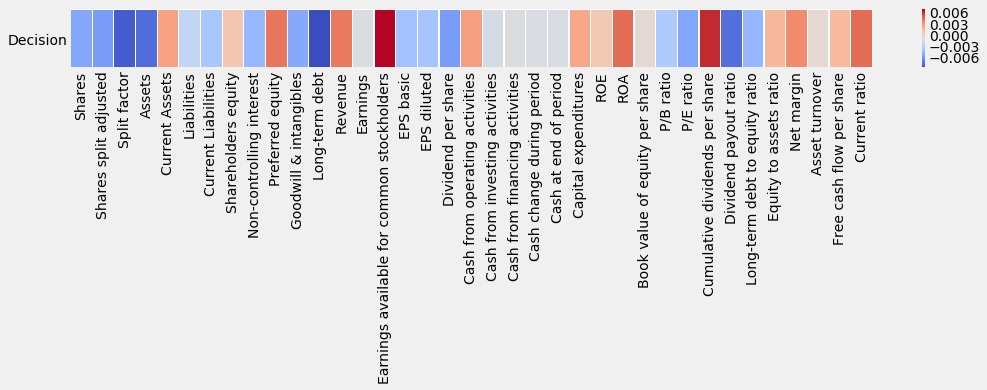

In [6]:
# Correlation DF of all classes
corr = final_df.corr().iloc[[-1],:-1]

# Plotting the Correlation DF as a heatmap
plt.figure(figsize=(16,1))
sns.heatmap(corr, annot=False, linewidths=.1, cmap="coolwarm")
plt.xticks()
plt.yticks(rotation=0)
plt.savefig("corr_dec.png")
plt.show()

## Feature Selection
Reducing the feature set for computational simplicity and potential improvement in accuracy.

### Feature Importances from the DF

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

In [8]:
forest = ExtraTreesClassifier(n_estimators=200)

# Setting the corresponding variables for our classifier
X = final_df.drop(['Decision'], 1)
y = final_df.Decision

# Fitting the classifier
%timeit forest.fit(X, y)

41.9 s ± 509 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# Determining the important features
importances = forest.feature_importances_

# The standard deviation among the trees for the important features
std = np.std([i.feature_importances_ for i in forest.estimators_], axis=0)

# Indexing and sorting the important features
indices = np.argsort(importances)[::-1]

### Plotting the most important features

Feature Rankings:
1. P/B ratio: 0.041909906666641
2. Assets: 0.03190539122023773
3. Shares split adjusted: 0.030704773393002472
4. Shares: 0.03024264332850007
5. P/E ratio: 0.030013530546340098
6. Asset turnover: 0.029719696288100655
7. Liabilities: 0.029610373589817142
8. Current Assets: 0.029523829394632776
9. Cash at end of period: 0.029522326162354406
10. Revenue: 0.02936444449372168


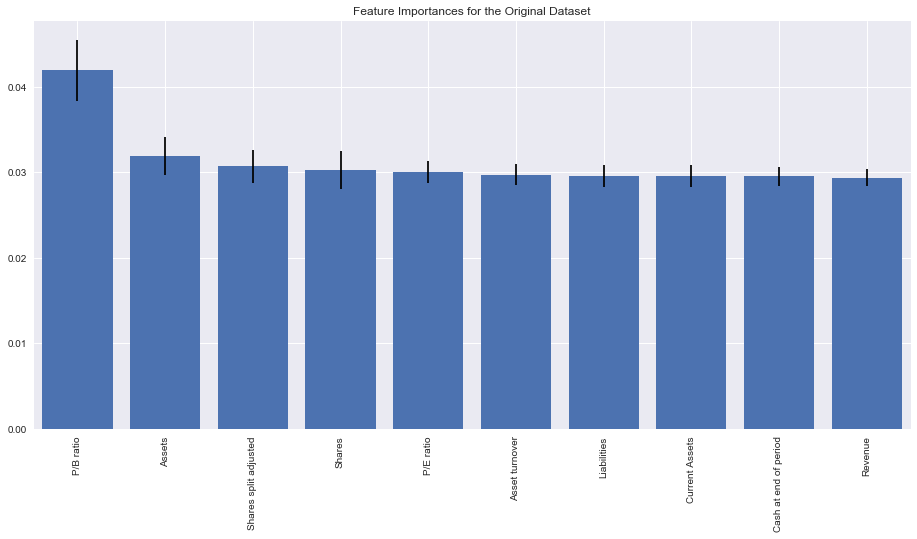

In [16]:
plt.style.use('seaborn')

print("Feature Rankings:")

# Showing the top 10 features
for i in range(10):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]}")
    
# Plotting the top 10 features
plt.figure(figsize=(14,7))

plt.title("Feature Importances for the Original Dataset")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align='center')

plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-.5, 9.5])
plt.show()

#### Selecting the Top 10 most important features
According to the feature importances from the original dataset.

In [27]:
# Assigning the top 10 features as a new DF
top10_df = final_df[X.columns[indices][:10]].join(final_df.Decision)
top10_df.head(5)

,P/B ratio,Assets,Shares split adjusted,Shares,P/E ratio,Liabilities,Asset turnover,Cash at end of period,Current Assets,Revenue,Decision
0,0.000000,3.011116,0.060170,0.060170,0.000000,2.212896,0.00000,-28.508772,1.505420,10.641140,0.0
1,-40.465919,6.911624,0.164196,0.164196,0.000000,9.182531,0.00000,-28.118609,5.675302,7.444668,0.0
2,-31.739130,7.640220,0.739888,0.739888,0.000000,8.034188,0.00000,41.678521,5.819611,26.292135,2.0
3,-2.335456,9.293769,0.088384,0.088384,0.000000,16.044304,0.00000,-56.526104,-3.430592,-15.747331,0.0
4,-28.260870,-1.390096,0.066338,0.066338,-25.917859,-5.535860,-6.47482,86.836028,-8.478301,-16.156283,2.0


### Exporting the Top 10 Dataframe

In [40]:
with open("top10_df.pkl", "wb") as fp:
    pickle.dump(top10_df, fp)

### Feature Importances from the Correlation DF
Determining the top 10 most important features based on their correlation value

In [63]:
top10_corr = corr.transpose().apply(abs).sort_values(by='Decision', ascending=False)[:10]
top10_corr

,Decision
Long-term debt,0.008738
Split factor,0.008156
Assets,0.007530
Dividend payout ratio,0.007513
Earnings available for common stockholders,0.006740
Cumulative dividends per share,0.006187
Dividend per share,0.005761
Shares split adjusted,0.005746
P/E ratio,0.005296
Shares,0.005244


In [68]:
top10_corr.index

Index(['Long-term debt', 'Split factor', 'Assets', 'Dividend payout ratio',
       'Earnings available for common stockholders',
       'Cumulative dividends per share', 'Dividend per share',
       'Shares split adjusted', 'P/E ratio', 'Shares'],
      dtype='object')

In [71]:
top10_corr_df = final_df[top10_corr.index].join(final_df.Decision)
top10_corr_df

,Long-term debt,Split factor,Assets,Dividend payout ratio,Earnings available for common stockholders,Cumulative dividends per share,Dividend per share,Shares split adjusted,P/E ratio,Shares,Decision
0,0.000000,0.0,3.011116,0.000000,26.717557,0.000000,0.000000,0.060170,0.000000,0.060170,0.0
1,0.000000,0.0,6.911624,0.000000,-6.626506,0.000000,0.000000,0.164196,0.000000,0.164196,0.0
2,0.000000,0.0,7.640220,0.000000,96.774194,0.000000,0.000000,0.739888,0.000000,0.739888,2.0
3,0.000000,0.0,9.293769,0.000000,-49.508197,0.000000,0.000000,0.088384,0.000000,0.088384,0.0
4,0.000000,0.0,-1.390096,0.000000,-37.662338,0.000000,0.000000,0.066338,-25.917859,0.066338,2.0
5,0.000000,0.0,-5.044053,0.000000,-328.125000,0.000000,0.000000,0.779867,-7.517850,0.779867,0.0
6,0.000000,0.0,-7.376479,0.000000,-165.296804,0.000000,0.000000,0.663831,62.125341,0.663831,2.0
7,0.000000,0.0,6.348610,0.000000,-320.279720,0.000000,0.000000,0.035544,104.033613,0.035544,1.0
8,0.000000,0.0,-3.002473,0.000000,-19.682540,0.000000,0.000000,0.083553,-100.000000,0.083553,0.0
9,0.000000,0.0,2.415635,0.000000,-9.881423,0.000000,0.000000,0.529539,0.000000,0.529539,0.0


### Exporting the DF of Top 10 Correlated Features

In [73]:
with open("top10_corr_df.pkl", "wb") as fp:
    pickle.dump(top10_corr_df, fp)